<a href="https://colab.research.google.com/github/benny-liang0623/maboo/blob/main/Brand/BCE/xlm_roberta_brand_classifier_BCE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XLM-RoBERTa Brand Classifier
Author: Meng-Chieh, Liu  
Date: 2022/5/18

## Import data and packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q pytorch-lightning
!pip install -q sentencepiece
!pip install -q transformers

In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

# Huggingface transformers
import transformers
# from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig, AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer, AdamW

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Import data and preprocessing

In [ ]:
dict_path = "/content/drive/Shareddrives/MABOO/brand/data/brand_dict_new.csv"
brand_dict = pd.read_csv(dict_path, encoding = "utf-8", index_col = "Unnamed: 0")
brand_dict.head(1)

,original,organized
0,21Plus,21plus


In [ ]:
len(brand_dict)

1094

In [ ]:
new_brand_dict = {}
for i in brand_dict.index:
  new_brand_dict[brand_dict['original'][i]] = brand_dict['organized'][i]

In [ ]:
train_path = "/content/drive/Shareddrives/MABOO/brand/data/brand_train.csv"
train_data = pd.read_csv(train_path)[["name","brand"]].dropna().reset_index(drop=True)
train_data.head(1)

,name,brand
0,元山熱水瓶YS-540AP,元山


In [ ]:
def intergrate_brand(x,new_brand_dict):
  try:
    return new_brand_dict[x]
  except:
    return x

In [ ]:
def claen_string(string):
  s_list = re.findall(r'[a-zA-Z0-9\u4e00-\u9fff]+',string)
  return "".join(s_list).lower()

In [ ]:
train_data["name"] = train_data["name"].map(claen_string)
train_data["brand"] = train_data["brand"].apply(intergrate_brand, args=[new_brand_dict,])

In [ ]:
train_data.shape

(70045, 2)

In [ ]:
clean_path = "/content/drive/Shareddrives/MABOO/brand/data/brand_final.csv"
clean_df = pd.read_csv(clean_path, encoding = "utf-8", index_col = "Unnamed: 0")
clean_df["name"] = clean_df["name"].map(claen_string)
clean_df['brand'] = clean_df['brand'].apply(intergrate_brand, args=[new_brand_dict,])

In [ ]:
def resampling(df, clean_df):
  brand_list = df["brand"].unique()
  clean_list = clean_df['brand'].unique()
  for brand in tqdm(brand_list):
    if brand in clean_list:
      temp_df = clean_df[clean_df["brand"]==brand]
    else:
      temp_df = df[df["brand"]==brand]
    if len(temp_df) > 80:
      temp_df = temp_df.sample(80, random_state=RANDOM_SEED)
    if len(temp_df) < 25:
      temp_df = temp_df.sample(25, random_state=RANDOM_SEED, replace=True)
    try:
      merge_df = pd.concat([merge_df,temp_df], ignore_index=True)
    except:
      merge_df = temp_df
  return merge_df

In [ ]:
train = resampling(train_data, clean_df)
train.shape

100%|██████████| 3448/3448 [00:34<00:00, 101.07it/s]


(103985, 2)

In [ ]:
train["brand"] = train["brand"].map(lambda x: [x])

In [ ]:
# encode y label
from sklearn.preprocessing import MultiLabelBinarizer

x = train["name"].tolist()
mlb = MultiLabelBinarizer()
yt = mlb.fit_transform(train["brand"])

In [ ]:
len(mlb.classes_)

3448

Split the dataset into training ,validation and test set.



In [ ]:
# from sklearn.model_selection import train_test_split
# # First Split for Train and Test
# x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=yt)
# # Next split Train in to training and validation
# # x_tr = x_train
# # x_val = x_test
# # y_tr = y_train
# # y_val = y_test

In [ ]:
# import pickle
# with open('/content/drive/Shareddrives/MABOO/brand/BCE2/x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
# with open('/content/drive/Shareddrives/MABOO/brand/BCE2/x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)
# with open('/content/drive/Shareddrives/MABOO/brand/BCE2/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('/content/drive/Shareddrives/MABOO/brand/BCE2/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)

In [ ]:
import pickle
with open('/content/drive/Shareddrives/MABOO/brand/BCE2/x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open('/content/drive/Shareddrives/MABOO/brand/BCE2/x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)
with open('/content/drive/Shareddrives/MABOO/brand/BCE2/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('/content/drive/Shareddrives/MABOO/brand/BCE2/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
len(x_train) ,len(x_test)

(83188, 20797)

In [ ]:
weight_df = pd.DataFrame(y_train)
weight_list = []
for i in tqdm(range(3448)):
  weight = (len(weight_df[i])-sum(weight_df[i])) / sum(weight_df[i])
  weight_list.append(round(weight))
pos_weight = torch.tensor(weight_list)
pos_weight

100%|██████████| 3448/3448 [01:31<00:00, 37.71it/s]


tensor([4158, 1299, 4158,  ..., 4158, 3616, 1299])

In [ ]:
# release RAM
train=None
x=None
yt=None
clean_df=None
train_data=None
brand_dict=None
weight_df=None

Preparing the Dataset and DataModule  
First create QTagDataset class based on the Dataset class, that readies the text in a format needed for the BERT Model

In [ ]:
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

Since we are using Pytorch Lightning for Model training - we will setup the QTagDataModule class that is derived from the LightningDataModule

In [ ]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=64,max_token_len=64):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self,stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer, max_len=self.max_token_len)
        self.val_dataset = QTagDataset(quest=self.val_text, tags=self.val_label, tokenizer=self.tokenizer, max_len=self.max_token_len)
        self.test_dataset = QTagDataset(quest=self.test_text, tags=self.test_label, tokenizer=self.tokenizer, max_len=self.max_token_len)
             
    def train_dataloader(self):
        return DataLoader (self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader (self.test_dataset, batch_size=self.batch_size)

In [ ]:
# Initialize the XLMR tokenizer
# MODEL_NAME = "xlm-roberta-base" 
# tokenizer = transformers.XLMRobertaTokenizerFast.from_pretrained(MODEL_NAME)

In [ ]:
# Initialize the XLNet tokenizer
MODEL_NAME = "bert-base-multilingual-uncased" 
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 50
BATCH_SIZE = 64
MAX_LEN = 64
LR = 2e-5
n_classes = len(mlb.classes_)

In [ ]:
# Instantiate and set up the data_module
# QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module = QTagDataModule(x_train,y_train,x_test,y_test,x_test,y_test,tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

# Train the Model
Setup the Classifier Model - dervived from LightningModule , similar to nn.module of PyTorch

In [ ]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=n_classes, steps_per_epoch=None, n_epochs=N_EPOCHS, lr=LR, pos_weight=pos_weight):
        super().__init__()

        self.num_labels = 1
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.linear_1 = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.roberta = XLMRobertaModel.from_pretrained(MODEL_NAME)
        # self.linear_1 = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        # output = self.roberta(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.linear_1(output.pooler_output)
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        return optimizer
        # warmup_steps = self.steps_per_epoch//3
        # total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        # scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)
        # return [optimizer], [scheduler]

In [ ]:
# Instantiate the classifier model
steps_per_epoch = len(x_train)//BATCH_SIZE
model = QTagClassifier(n_classes=n_classes, steps_per_epoch=steps_per_epoch, n_epochs=N_EPOCHS, lr=LR, pos_weight=pos_weight)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Initialize Pytorch Lightning callback for Model checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='QTag-{epoch:02d}-{val_loss:.4f}',
    save_top_k=3,
    mode='min',
)

In [ ]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS, gpus =1 , callbacks=[checkpoint_callback], progress_bar_refresh_rate = 30, default_root_dir='/content/drive/Shareddrives/MABOO/brand/BCE2')

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Test RAM affordability
# trainer.test(model,datamodule=QTdata_module)

In [ ]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

Missing logger folder: /content/drive/Shareddrives/MABOO/brand/BCE2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name      | Type              | Params
------------------------------------------------
0 | bert      | BertModel         | 167 M 
1 | linear_1  | Linear            | 2.7 M 
2 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
170 M     Trainable params
0         Non-trainable params
170 M     Total params
680.032   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir /content/drive/Shareddrives/MABOO/brand/model_clean_brand_BCE/lightning_logs/

# Evaluate Model

In [ ]:
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

In [ ]:
# load model
model = QTagClassifier.load_from_checkpoint("/content/drive/Shareddrives/MABOO/brand/BCE2/lightning_logs/version_0/checkpoints/QTag-epoch=15-val_loss=0.0144.ckpt")
model = model.to(device) # moving model to cuda
model.eval()

In [ ]:
# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [ ]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
flat_pred_outs.shape , flat_true_labels.shape

((20797, 3448), (20797, 3448))

In [ ]:
max(flat_pred_outs[0])

0.99950874

In [ ]:
# release RAM
x_train = None
y_train = None
y_test = None
pos_weight = None
QTdata_module = None

### Get max probabilities

In [ ]:
from sklearn import metrics

In [ ]:
#define candidate threshold values
threshold  = np.arange(0.1,1,0.1)

In [ ]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob, thresh):
    y_pred = []
    count = 1
    for tag_label_row in pred_prob:
        temp=[0] * n_classes
        new_tag_label_row = tag_label_row.tolist()
        max_value = max(new_tag_label_row)
        if max_value > thresh:
          max_index = new_tag_label_row.index(max_value)
          temp[max_index] = 1

        y_pred.append(temp)

    return y_pred

In [ ]:
def get_one(x):
  try:
    return x[0]
  except:
    return "Other"

In [ ]:
scores=[] # Store the list of f1 scores for prediction on each threshold

for thresh in tqdm(threshold):
    
    y_pred_labels = classify(flat_pred_outs,thresh)
    y_pred = mlb.inverse_transform(np.array(y_pred_labels))
    y_act = mlb.inverse_transform(flat_true_labels)

    df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})
    df['Actual Tags'] = df['Actual Tags'].map(get_one)
    df['Predicted Tags'] = df['Predicted Tags'].map(get_one)
    scores.append(metrics.f1_score(df['Actual Tags'],df['Predicted Tags'], average="macro"))

100%|██████████| 9/9 [02:27<00:00, 16.42s/it]


In [ ]:
import matplotlib.pyplot as plt

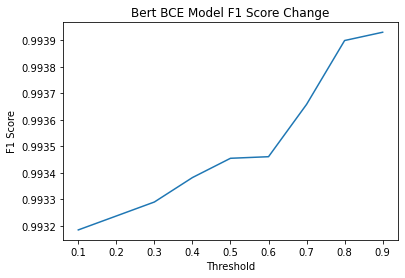

In [ ]:
plt.plot(np.arange(0.1,1,0.1), scores)
plt.xticks(np.arange(0.1,1,0.1))
plt.title("Bert BCE Model F1 Score Change")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

Optimal Threshold Value = 0.9


In [ ]:
y_pred_labels = classify(flat_pred_outs, 0.8)
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)
df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [ ]:
df['Actual Tags'] = df['Actual Tags'].map(get_one)
df['Predicted Tags'] = df['Predicted Tags'].map(get_one)

In [ ]:
df.sample(10)

,Body,Actual Tags,Predicted Tags
5034,lestar360度奈米兒童萌寵造型牙刷兒童牙刷,lestar,lestar
9109,rohto淡彩潤唇膏黃粉紅24g,日本樂敦rohto,日本樂敦rohto
19289,韓國市集vt巨無霸牙刷,VT,VT
15333,unlabel植物高保濕卸妝水500ml混合油,Unlabel,Unlabel
5216,c嬌生嬰兒溫和洗髮露500ml,嬌生,嬌生
9056,滿箱免運紐麥福紐西蘭生乳全脂純牛奶1l保久乳牛乳紐麥福保久乳紐麥福牛奶,紐麥福,紐麥福
12994,領券免運唯白衛生棉告別悶臭癢嚴立婷愛用推薦淨嫩透白sod草本抑菌衛生棉日用夜用護墊涼感衛生棉,唯白 VD,唯白 VD
7180,保力達蠻牛icash20元氣發聲瓶含運費,保力達,保力達
17365,克寧100純生乳奶粉750g50g原售價339元促銷價299元,克寧klim,克寧klim
1503,中華豪井1200w金爵吹風機zhed2800,中華豪井,中華豪井


In [ ]:
metrics.f1_score(df['Actual Tags'],df['Predicted Tags'], average="macro")

0.9938992459496585

In [ ]:
df.to_csv("validation_result.csv", encoding="utf-8")

In [ ]:
# release RAM
df = None
x_test = None

# Predict on test data

In [ ]:
def predict_single_data(text, model = model, tokenizer = tokenizer, device = device, max_length=64) :
  text = tokenizer.encode_plus(
              text,
              None,
              add_special_tokens=True, 
              max_length= max_length,
              padding = 'max_length',
              return_token_type_ids= False,
              return_attention_mask= True, 
              truncation=True, 
              return_tensors = 'pt'
            )
  input_ids = text['input_ids'].flatten()
  attention_mask = text['attention_mask'].flatten()
  input_ids = torch.unsqueeze(input_ids, 0).to(device)
  attention_mask = torch.unsqueeze(attention_mask, 0).to(device)
  pred_out = model(input_ids,attention_mask)
  pred_out = torch.sigmoid(pred_out)[0].detach().cpu().numpy()
  return pred_out

原有品牌

In [ ]:
max(predict_single_data("heme喜蜜輕透柔光粉底液SPF5030ml2入組"))

0.99941456

In [ ]:
max(predict_single_data("辰屏大薄鹽醬油非基改黃豆"))

0.99772054

測試一些新品牌

In [ ]:
max(predict_single_data("cm康媚絲洗髮精強化"))

0.19765675

In [ ]:
max(predict_single_data("alesoi深呼吸胺基酸保濕洗面乳保濕山茶花洗面乳胺基酸洗面乳維他命b5玻尿酸納植物萃取天然水潤感"))

0.33618453

### Classifier

In [ ]:
test_path = "/content/drive/Shareddrives/MABOO/brand/data/brand_test(question).csv"
test_data = pd.read_csv(test_path, encoding = "utf-8")[['name','brand']]
test_data["name"] = test_data["name"].map(claen_string)

In [ ]:
test_data.head(1)

,name,brand
0,heme喜蜜輕透柔光粉底液spf5030ml2入組,NaN


In [ ]:
len(test_data)

97159

In [ ]:
class QuestionDataset (Dataset):
    def __init__(self, quest, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            
        }

In [ ]:
text_list = test_data['name']

In [ ]:
predit_dataloader = DataLoader(QuestionDataset(text_list,tokenizer,64) ,batch_size=256)
outputs = []
with torch.no_grad():
  for batch in tqdm(predit_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    _result = model(input_ids,attention_mask)
    _result = torch.sigmoid(_result)
    outputs.append(_result.cpu().numpy())
outputs = np.concatenate(outputs)
outputs.shape

100%|██████████| 380/380 [06:26<00:00,  1.02s/it]


(97159, 3448)

In [ ]:
import pickle
# with open('/content/drive/Shareddrives/MABOO/brand/BCE2/outputs.pkl', 'wb') as f:
#     pickle.dump(outputs, f)
with open('/content/drive/Shareddrives/MABOO/brand/BCE2/outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

In [ ]:
# release RAM
predit_dataloader = None

In [ ]:
test_y = np.array(classify(outputs, 0.5))
# test_y_label = mlb.inverse_transform(test_y)

In [ ]:
outputs = None

In [ ]:
test_data['brand'] = mlb.inverse_transform(test_y)
test_data['brand'] = test_data['brand'].map(get_one)

In [ ]:
test_data.to_csv("/content/drive/Shareddrives/MABOO/brand/BCE2/test_data.csv", encoding="utf-8")

In [ ]:
other = test_data[test_data['brand']=="Other"]
other.to_csv("/content/drive/Shareddrives/MABOO/brand/BCE2/other.csv", encoding="utf-8")

In [ ]:
len(other)

5987

In [ ]:
5987/97159

0.06162064245206311

### Web Crawling for new brand

In [ ]:
from bs4 import BeautifulSoup
import requests as rq
import time

In [ ]:
def get_brand_name(keyword):

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36'}
    try:
        url = 'https://m.momoshop.com.tw/search.momo?searchKeyword={}&couponSeq=&cpName=&searchType=1&cateLevel=-1&cateCode=-1&ent=k&_imgSH=fourCardStyle'.format(keyword)
        response = rq.get(url, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, features="html.parser")
            table =  soup.find_all('li' ,attrs={"class":"goodsItemLi" })[0]
            products = table.find_all("a")
            for product in products:
                try:
                  href = product.get("href")
                  if "http" not in href:
                      in_url  = 'https://m.momoshop.com.tw'+href
                      response = rq.get(in_url, headers=headers)
                      if response.status_code == 200:
                          soup = BeautifulSoup(response.text, features="html.parser")
                          brand_name = soup.find_all('a' ,attrs={"class":"brandNameTxt" })[0]
                          return brand_name.get_text()
                except:
                    pass
                time.sleep(0.1)
        return None
    except:
        return None